<a href="https://colab.research.google.com/github/jf-v/ML-Price_prediction_SMA/blob/main/ML_Price_movement_prediction_using_SMA_indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for price movement prediction using SMA indicators 


* Data for model training from: [CryptoDataDownload](https://www.cryptodatadownload.com/)
* Data for predictions obtained with [cryptowatch-sdk](https://github.com/cryptowatch/cw-sdk-python)
* Model save and load with pickle library


How to use this notebook:


**Create model**

*   **Create and train a new model**: execute cells from 1 to 6. Can save the model to local computer or google drive on cell 7


**Load model (instead of creating it again)**

*   **Load a pretrained model** on cell 8. Execute first cells 1,2 and 4


**Predictions**

*   Execute **Prediction Init**(cell 9). Can be used recent price data from  different exchanges or input a custom historic bar data

*   After the model was created or loaded and the prediction init cell was executed, **Run the model prediction**(cell 10) any times as needed. It can predict for a historic bar selected by shift toward current bar(0), or for a bar series starting from current to do backtesting.


** DISCLAIMER: The resources available on this project are purely and exclusively for educational purposes, and are not intended as, and shall not be understood or construed as, financial advice. I am not an attorney, accountant of financial advisor, nor am I holding myself out to be, and the information contained on this project are not a substitute for financial advice from a professional.





# Create model

In [1]:
#@title # 1.  **Download price data** and convert it into a DataFrame
#@markdown * Data from cryptodatadownload.com
#@markdown * Check available symbols and timeframes on https://www.cryptodatadownload.com/data/bitstamp/   links to each csv
#@markdown * Symbol: BTCUSDT, ETHUSDT and more available
Symbol = "BTCUSDT" #@param {type:"string"}
Timeframe = "1h" #@param ["1h", "d"]


# download price data of binance
data_url='https://www.cryptodatadownload.com/cdd/Bitstamp_'+Symbol+'_'+Timeframe+'.csv' 
data_path='data.csv'
!wget -O $data_path $data_url


# Load the historical price data to a dataframe
import pandas as pd
df = pd.read_csv(data_path, skiprows=1)
df.head()
print('Price data shape: '+str(df.shape))

--2023-01-01 23:26:48--  https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSDT_1h.csv
Resolving www.cryptodatadownload.com (www.cryptodatadownload.com)... 35.173.69.207
Connecting to www.cryptodatadownload.com (www.cryptodatadownload.com)|35.173.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 623966 (609K) [text/csv]
Saving to: ‘data.csv’

data.csv            100%[===================>] 609.34K  2.43MB/s    in 0.2s    

2023-01-01 23:26:49 (2.43 MB/s) - ‘data.csv’ saved [623966/623966]

Price data shape: (6580, 9)


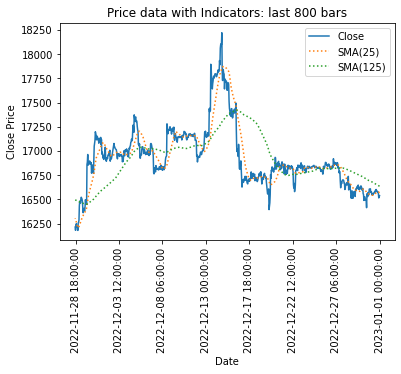

In [2]:
#@title # 2.  Calculate **indicators**
sma_1 = 25 #@param {type:"integer"}
sma_2 = 125 #@param {type:"integer"}
show_previous_bars = 800 #@param {type:"integer"}
# Calculate the indicators based on the 'close' values
df['indicator_1'] = df['close'][::-1].rolling(sma_1).mean()[::-1]  # reverse the column, apply rolling and mean, then reverse it again
df['indicator_2'] = df['close'][::-1].rolling(sma_2).mean()[::-1]  # reverse the column, apply rolling and mean, then reverse it again


# Plot the indicator values for the last bars

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
bars = show_previous_bars

#   Define plot x,y
x = df['date'][:bars]
y = df['close'][:bars]
plt.plot(x,y,label='Close')

#   Calculate indicators
plt.plot(df['indicator_1'][:bars],label='SMA('+str(sma_1)+')',linestyle='dotted')
plt.plot(df['indicator_2'][:bars],label='SMA('+str(sma_2)+')',linestyle='dotted')
plt.legend()

#   Set title and labels
plt.title('Price data with Indicators: last '+str(show_previous_bars)+' bars')
plt.xlabel('Date')
plt.ylabel('Close Price')

#   Fix dates ticks
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticks(xticks[::len(xticks) //7])  # set new tick positions
ax.tick_params(axis='x', rotation=90)     # set tick rotation

#   Invert x orientation
plt.gca().invert_xaxis()

#   Set graph size and show it
plt.rcParams["figure.figsize"] = (20,7)
plt.show()


In [6]:
#@title # 3.  Prepare a **new column with future prices** by a shift bar. Later, use this as a **target** to train the model for price movement prediction
#@markdown * Price shift will determine the time target for the prediction, and is based on the price data timeframe. If is H1, then the shift will be the amount of hours toward future for the prediction
future_price_shift = 10 #@param {type:"integer"}

import numpy as np

# Shift the close price column by 5 slots to create the target column
df["price_change"] = df["close"].shift(-(future_price_shift))

# Calculate the change in price between the current and the next slots
df["price_change"] = df["price_change"] - df["close"]

# Create a target column that indicates whether the price will go up (1) or down (-1)
df["target"] = np.where(df["price_change"] > 0, 1, -1)

# Drop rows with missing values (there will be some at the end of the dataframe)
df.dropna(inplace=True)

# Define the labels
y = df["target"]

Define the **input columns**

In [8]:
#@title # 4.  Define the model **inputs**
# Preprocess the data to prepare it for training the model:

from sklearn.preprocessing import StandardScaler

# Select the relevant features to use as input for the model
X = df[["close", "indicator_1", "indicator_2"]]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
#@title # 5.  **Init** the model and **train** it: RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Define the model and its parameters
model = RandomForestClassifier(n_estimators=100, max_depth=10)

# Train the model
model.fit(X_scaled, y)

# Evaluate the model using cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_scaled, y, cv=5)

# Print the mean and standard deviation of the scores
print(f"Mean score: {np.mean(scores):.2f}")
print(f"Standard deviation: {np.std(scores):.2f}")

Mean score: 0.58
Standard deviation: 0.06


In [14]:
#@title # 6.  Apply **Hyperparameter tuning** using grid search
from sklearn.model_selection import GridSearchCV

# Define the model
model = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [5, 10, 20, None],
}

# Use grid search to find the best combination of hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_scaled, y)

# Print the best combination of hyperparameters
print('Best combination of hyperparameters:')
print(grid_search.best_params_)

# Use the best combination of hyperparameters to train the model
model = RandomForestClassifier(**grid_search.best_params_)
model.fit(X_scaled, y)

# Evaluate the model using cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)

# Print the mean and standard deviation of the scores
print(f"Mean score: {np.mean(scores):.2f}")
print(f"Standard deviation: {np.std(scores):.2f}")

Best combination of hyperparameters:
{'max_depth': None, 'n_estimators': 100}
Mean score: 0.59
Standard deviation: 0.06


In [15]:
#@title # 7.  **Save** trained model with pickle library
Download = False #@param {type:"boolean"}
Save_to_drive = True #@param {type:"boolean"}
model_name = "ML-Binance_BTCUSDT_H1-sma25_125-target_shift_10" #@param {type:"string"}

content_folder=''


#   Prepare drive

if Save_to_drive:
  import os 
  from google.colab import drive
  drive.mount('/content/gdrive')      # mount drive
  
  content_folder = "/content/gdrive/MyDrive"  
  os.chdir(content_folder)    
  
  folder = "ML-Price_prediction_SMA"
  if os.path.isdir(folder)==False:
    os.mkdir(folder)    
  content_folder += "/"+folder+'/'
  

#   Save model to pickle file

import pickle

file_path = content_folder+model_name+'.pkl'
with open(file_path, 'wb') as model_file:
  pickle.dump(model, model_file)
  if Save_to_drive: print("Saved on folder: "+content_folder)


#   Download to local computer

if Download:       
  from google.colab import files       
  files.download(file_path)  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Saved on folder: /content/gdrive/MyDrive/ML-Price_prediction_SMA/


______________________________________________________________________________________________________________________________________________

# Load model

In [11]:
#@title # 8.  **Load** pretrained model with pickle library
#@markdown # Execute cells 1, 2, 4  before to run this one
#@markdown To load a saved model from a Pickle file, all you need to do is pass the “pickled” model into the Pickle load() function and it will be deserialized. By assigning this back to a model object, you can then run your original model’s predict() function, pass in some test data and get back an array of predictions.
model_name = "ML-Binance_BTCUSDT_H1-sma25_125-target_shift_10" #@param {type:"string"}
Load_from_drive = True #@param {type:"boolean"}
#@markdown * Input the sma periods used on the loaded model
sma_1 = 25 #@param {type:"integer"}
sma_2 = 125 #@param {type:"integer"}


model_loaded=True
content_folder=''

#   Prepare drive

if Load_from_drive:
  import os 
  from google.colab import drive
  drive.mount('/content/gdrive')      # mount drive
  
  content_folder = "/content/gdrive/MyDrive"  
  os.chdir(content_folder)    
  
  folder = "ML-Price_prediction_SMA"
  if os.path.isdir(folder)==False:
    print("Error: default models folder doesn't exist on drive")
  content_folder += "/"+folder+'/'


#   Load model from pickle file

import pickle
model = pickle.load(open(content_folder+model_name+'.pkl', 'rb'))
if model != None: print('Success to load model: '+model_name)
# model.predict(X_test)     use it like this



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Success to load model: ML-Binance_BTCUSDT_H1-sma-shift_10


__________________________________________________________________________________________________________________________

# Predictions

In [ ]:
#@title # 9.  Prediction **init**
Use_cryptowatch_prices = True #@param {type:"boolean"}

#   Check the model
try:
  model
except NameError as e:
  print('There is not available model yet. Load or create a new one first\n')


#   Use recent price data from binance exchange, to make predictions

if Use_cryptowatch_prices:
  print('Installing cryptowatch-sdk to get prices data')
  !pip install cryptowatch-sdk
  import cryptowatch as cw


#   Predictions function, it will return a string with the result

def predict(close,indicator_1,indicator_2,probability_threshold):
  # Select the features for the new data
  inputs = {'close':[close], 
            'indicator_1':[indicator_1], 
            'indicator_2':[indicator_2]}
  X_new = pd.DataFrame(inputs)

  # Normalize the data
  #X_new_scaled = scaler.fit_transform(X_new)
  X_new_scaled = scaler.transform(X_new)

  # Make a prediction using the model
  prediction = model.predict(X_new_scaled)

  # Make a probabilities prediction using the model
  probabilities = model.predict_proba(X_new_scaled)
  probability = str(probabilities[[0]]).split()

  # Return the prediction: Outputs either 1(buy) or -1(sell)
  result = ""
  p = 0
  if prediction[0] == 1:  
    p = float(probability[1].replace("]","")[0:4])*100
    result+=("B U Y    ("+str(p)+" % probability)")
  else:                   
    p = float(probability[0].replace("[","")[0:4])*100
    result+=("S E L L  ("+str(p)+" % probability)")
  if p >= probability_threshold:
    result += "  ✓"
  return result

* Prediction target shift was determined on the model training

Bar Series prediction, starting from current bar at 2023-01-02 05:00:00



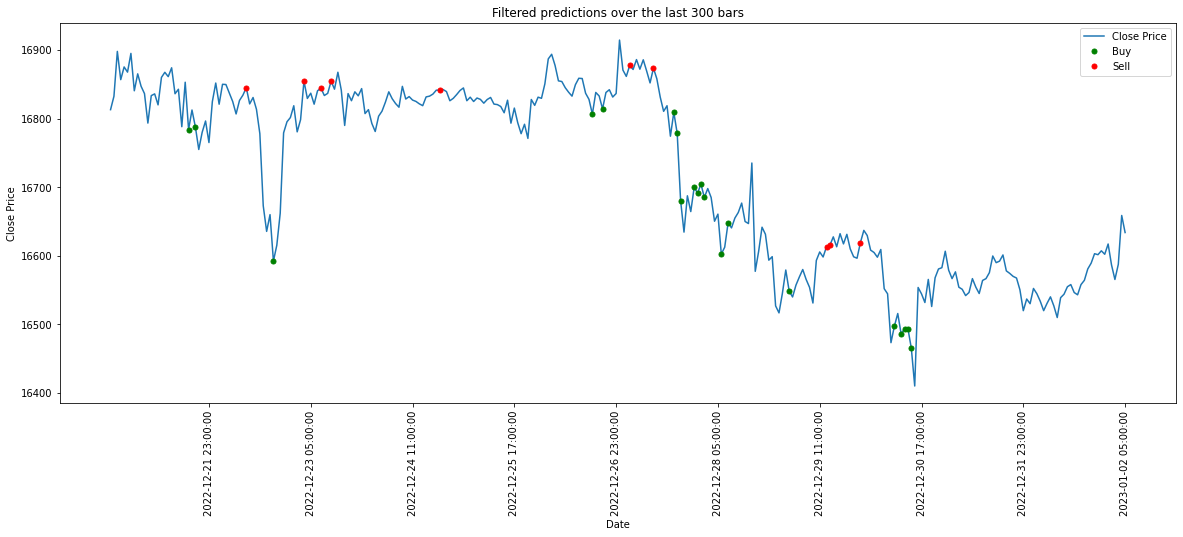

In [149]:
#@title # 10.  Make price movement **predictions**
#@markdown __________________________________________________________________________________
#@markdown # Use recent prices from cryptowatch
#@markdown * Make sure that **Use_cryptowatch_prices** was **enabled** on the prediction init cell
#@markdown * Enable **refresh data** only once at every new bar or when changing symbol, timeframe or exchange, to avoid reaching the free requests limit
refresh_data = True #@param {type:"boolean"}
#@markdown * Enter the same symbol and timeframe than the one used for training the model
symbol = "BTCUSDT" #@param {type:"string"}
timeframe = "1h" #@param ["1h","1d"]
#@markdown * Select exchange
exchange = "Huobi" #@param ["Binance", "Huobi", "Kraken", "Coinbase Pro", "Crypto.com", "Bitfinex", "Bitstamp"]
#@markdown * Prediction mode **Single Bar**: enter the bar shift that will be used for prediction, starting from current bar as 0
#@markdown * Prediction mode **Bar Series**: enter the amount of bars to get prediction, starting from the current bar
Prediction_mode = "Bar Series" #@param ["Single Bar", "Bar Series"]
Prediction_shift_or_range = 300 #@param {type:"integer"}
#@markdown __________________________________________________________________________________
#@markdown # Use custom prices
#@markdown * Make sure that **Use_cryptowatch_prices** was **disabled** on the prediction init cell
#@markdown * Last bar or older. Don't use current bar values until is already closed
Close = 16608.63 #@param {type:"number"}
SMA_1 = 16596.32 #@param {type:"number"}
SMA_2 = 16739.13 #@param {type:"number"}
#@markdown __________________________________________________________________________________
#@markdown # Prediction probability **threshold** filter (recommended >94%)
probability_threshold = 98 #@param {type:"slider", min:1, max:100, step:1}
show_predictions_as_string_list = False #@param {type:"boolean"}

##############################################################################

print('* Prediction target shift was determined on the model training\n')

#   Use recent prices for prediction from cryptowatch

if Use_cryptowatch_prices:

  # Get price data
  if refresh_data:
    candles = cw.markets.get(exchange+":"+symbol, ohlc=True)
  
  # Convert cryptowatch response into a DataFrame
  if timeframe=='1h': cw_df = pd.DataFrame(candles.of_1h)
  else:               cw_df = pd.DataFrame(candles.of_1d)
  cw_df.columns = ['close_timestamp', 'open', 'high', 'low', 'close', 'volume_base', 'volume_quote']
  cw_df = cw_df.sort_values(['close_timestamp'],ascending=[False])
  
  # Calculate the indicators based on the 'close' values
  cw_df['indicator_1'] = cw_df['close'][::-1].rolling(sma_1).mean()[::-1]  # reverse the column, apply rolling and mean, then reverse it again
  cw_df['indicator_2'] = cw_df['close'][::-1].rolling(sma_2).mean()[::-1]  # reverse the column, apply rolling and mean, then reverse it again
 
  # Add time column
  cw_df['time'] =  pd.to_datetime(cw_df['close_timestamp'],unit='s')  
  
  # Define series limit bar
  b = Prediction_shift_or_range

  #   Make a prediction series

  if Prediction_mode == 'Bar Series':
    
    prediction_series = []       
    print("Bar Series prediction, starting from current bar at "+cw_df['time'][0:1].astype(str).tolist()[0]+'\n')
    for b in range(Prediction_shift_or_range): 
      prediction = predict(cw_df['close'][b:(b+1)],cw_df['indicator_1'][b:(b+1)],cw_df['indicator_2'][b:(b+1)],probability_threshold)
      prediction_series.append(prediction)      

    # Prepare time and close price series for x and y axis
    y = cw_df['close'][:Prediction_shift_or_range].tolist()
    x = cw_df['time'][:Prediction_shift_or_range].astype(str).tolist()

    # Define buy and sell signals positions to plot the dots
    sell = []
    buy = []
    for i in range(len(x)):  
      if '✓' in prediction_series[i]:
        if 'S E L L' in prediction_series[i]: sell.append(i)
        if 'B U Y' in prediction_series[i]:   buy.append(i)

    # Plot the line
    plt.plot(x, y, label='Close Price')

    # Plot the signals
    plt.plot(buy, [y[i] for i in buy], 'o', color='green', markersize=5,label='Buy')
    plt.plot(sell, [y[i] for i in sell], 'o', color='red', markersize=5,label='Sell')

    #   Set title and labels
    plt.legend()
    plt.title('Filtered predictions over the last '+str(Prediction_shift_or_range)+' bars')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    #   Fix dates ticks
    ax = plt.gca()
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::len(xticks) //10])   # set new tick positions
    ax.tick_params(axis='x', rotation=90)       # set tick rotation

    #   Invert x orientation
    plt.gca().invert_xaxis()

    # Show the plot
    plt.show()

    #   Print predictions log as strings
    if show_predictions_as_string_list:
      for b in range(Prediction_shift_or_range): 
        print('Bar '+str(b)+':    '+prediction_series[b]+'\n')


  #  Make a single bar prediction selected by shift

  else:
    print("Prediction for bar "+str(b)+" opened on "+cw_df['time'][b:b+1].astype(str).tolist()[0]+'\n')
    print(predict(cw_df['close'][b:(b+1)],cw_df['indicator_1'][b:(b+1)],cw_df['indicator_2'][b:(b+1)],probability_threshold))


#   Use custom prices for a single bar prediction

else:  
  print(predict(Close,SMA_1,SMA_2,probability_threshold))




__________________________________________________________________________________________________________________________